In [1]:
import numpy as np
import random
import math
import itertools
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# **Neuron Class**

In [2]:
class Neuron:
    def __init__(self, dimensions: int, grid_position: Tuple[int, ...] = None, initial_position: np.ndarray = None):
        """
        Initializes a neuron with a position in the input space and its grid position.

        Parameters:
        - dimensions: Dimension of the input data.
        - grid_position: Tuple indicating the neuron's position in the grid.
        - initial_position: Optional initial position of the neuron in the input space.
        """
        self.grid_position = grid_position if grid_position is not None else tuple()
        if initial_position is not None:
            self.position = np.array(initial_position, dtype=float)
        else:
            self.position = np.random.rand(dimensions)  # Random initialization within unit cube

    def update_position(self, delta: np.ndarray):
        """
        Updates the neuron's position based on the delta.

        Parameters:
        - delta: Adjustment vector to be added to the neuron's position.
        """
        self.position += delta


# **SOM Class**

In [3]:
class SOM:
    def __init__(
        self,
        input_dim: int,
        grid_dims: Tuple[int, ...],
        learning_rate_initial: float,
        learning_rate_end: float,
        neighborhood_size_initial: float,
        g: int,
        som_id: int
    ):
        """
        Initializes a single Self-Organizing Map (SOM).

        Parameters:
        - input_dim: Dimension of the input data.
        - grid_dims: Tuple indicating the grid size (f1, f2, ..., fg).
        - learning_rate_initial: Initial learning rate (η0).
        - learning_rate_end: Final learning rate (η_end).
        - neighborhood_size_initial: Initial neighborhood size (s0).
        - g: Grid dimension (number of grid axes, up to 5).
        - som_id: Identifier for the SOM.
        """
        self.input_dim = input_dim
        self.grid_dims = grid_dims  # Tuple like (f1, f2, ..., fg)
        self.g = g  # Grid dimension
        self.som_id = som_id

        # Initialize neurons in an n-dimensional grid
        self.neurons: List[Neuron] = []
        grid_ranges = [range(dim) for dim in grid_dims]
        for grid_position in itertools.product(*grid_ranges):
            neuron = Neuron(dimensions=input_dim, grid_position=grid_position)
            self.neurons.append(neuron)

        # Learning parameters
        self.learning_rate_initial = learning_rate_initial
        self.learning_rate_end = learning_rate_end
        self.neighborhood_size_initial = neighborhood_size_initial
        self.neighborhood_size = neighborhood_size_initial

        # Time parameters
        self.time = 0
        self.max_time = 1000  # Default value; can be set during training

    def find_winner(self, input_vector: np.ndarray) -> Tuple[Neuron, float]:
        """
        Finds the winner neuron in this SOM for the given input_vector.

        Parameters:
        - input_vector: The input data vector.

        Returns:
        - winner_neuron: The neuron object that is the winner.
        - min_dist: Minimum distance found.
        """
        min_dist = float('inf')
        winner_neuron = self.neurons[0]
        for neuron in self.neurons:
            dist = np.linalg.norm(input_vector - neuron.position)
            if dist < min_dist:
                min_dist = dist
                winner_neuron = neuron
        return winner_neuron, min_dist

    def update_learning_parameters(self, current_time: int):
        """
        Updates the learning rate and neighborhood size based on the current_time.

        Parameters:
        - current_time: The current iteration number.
        """
        # ccccc
        self.learning_rate = self.learning_rate_initial * math.exp(-current_time / self.max_time)
        if self.learning_rate < self.learning_rate_end:
            self.learning_rate = self.learning_rate_end

        self.neighborhood_size = self.neighborhood_size_initial * math.exp(-current_time / self.max_time)

    def gaussian_neighborhood(self, distance: float, neighborhood_size: float) -> float:
        """
        Gaussian neighborhood function.

        Parameters:
        - distance: Distance between neurons on the grid.
        - neighborhood_size: Current neighborhood size.

        Returns:
        - Influence factor based on the Gaussian function.
        """
        return math.exp(-(distance ** 2) / (2 * (neighborhood_size ** 2)))

    def grid_distance(self, pos1: Tuple[int, ...], pos2: Tuple[int, ...]) -> float:
        """
        Calculates the Euclidean distance between two grid positions.

        Parameters:
        - pos1: Grid position tuple of the first neuron.
        - pos2: Grid position tuple of the second neuron.

        Returns:
        - Euclidean distance between pos1 and pos2.
        """
        return math.sqrt(sum((a - b) ** 2 for a, b in zip(pos1, pos2)))

    def get_neighboring_grid_positions(self, grid_position: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        """
        Finds all neighboring grid positions for a given grid position.

        Neighbors are defined as positions that differ by exactly ±1 in one dimension.

        Parameters:
        - grid_position: The grid position tuple of the neuron.

        Returns:
        - List of neighboring grid position tuples.
        """
        neighbors = []
        for dim in range(len(self.grid_dims)):
            for delta in [-1, 1]:
                neighbor = list(grid_position)
                neighbor[dim] += delta
                # Check boundaries
                if 0 <= neighbor[dim] < self.grid_dims[dim]:
                    neighbors.append(tuple(neighbor))
        return neighbors

    def update_neurons(self, input_vector: np.ndarray, winner_neuron: Neuron, current_time: int):
        """
        Updates the neurons in the SOM based on the input_vector and the winner neuron.

        Parameters:
        - input_vector: The input data vector.
        - winner_neuron: The neuron object that is the winner.
        - current_time: The current iteration number.
        """
        self.update_learning_parameters(current_time)
        winner_grid_pos = winner_neuron.grid_position

        # Precompute neighbors to avoid recalculating distances
        neighbors = self.get_neighboring_grid_positions(winner_grid_pos)

        # Update winner and its neighbors
        for neuron in self.neurons:
            grid_dist = self.grid_distance(winner_grid_pos, neuron.grid_position)
            influence = self.gaussian_neighborhood(grid_dist, self.neighborhood_size)
            if influence > 0:
                delta = self.learning_rate * influence * (input_vector - neuron.position)
                neuron.update_position(delta)

    def train(self, data: np.ndarray, max_iterations: int):
        """
        Trains the SOM with the provided data.

        Parameters:
        - data: Array of input vectors.
        - max_iterations: Number of training iterations.
        """
        self.max_time = max_iterations
        for t in range(max_iterations):
            input_vector = data[t % len(data)]
            winner_neuron, _ = self.find_winner(input_vector)
            self.update_neurons(input_vector, winner_neuron, t)

    def get_centers(self) -> List[np.ndarray]:
        """
        Returns the centers of all neurons in the SOM.

        Returns:
        - centers: List of neuron positions as numpy arrays.
        """
        return [neuron.position.copy() for neuron in self.neurons]


# **Multi-SOM Class**

In [4]:
class MSOM:
    def __init__(
        self,
        input_dim: int,
        M: int,
        grid_dims_list: List[Tuple[int, ...]],
        learning_rate_initial: float,
        learning_rate_end: float,
        neighborhood_size_initial: float,
        g: int
    ):
        """
        Initializes the Multi-Self-Organizing Map (M-SOM).

        Parameters:
        - input_dim: Dimension of the input data.
        - M: Number of partner SOMs.
        - grid_dims_list: List of grid dimension tuples for each SOM.
        - learning_rate_initial: Initial learning rate for all SOMs.
        - learning_rate_end: Final learning rate for all SOMs.
        - neighborhood_size_initial: Initial neighborhood size for all SOMs.
        - g: Grid dimension (number of grid axes, up to 5).
        """
        assert len(grid_dims_list) == M, "grid_dims_list must have M tuples."
        assert all(1 <= len(grid_dims) <= 5 for grid_dims in grid_dims_list), "Each grid_dims tuple must have between 1 and 5 dimensions."

        self.input_dim = input_dim
        self.M = M
        self.g = g
        self.soms: List[SOM] = []
        for m in range(M):
            grid_dims = grid_dims_list[m]
            som = SOM(
                input_dim=input_dim,
                grid_dims=grid_dims,
                learning_rate_initial=learning_rate_initial,
                learning_rate_end=learning_rate_end,
                neighborhood_size_initial=neighborhood_size_initial,
                g=g,
                som_id=m
            )
            self.soms.append(som)

    def find_global_winner(
        self, input_vector: np.ndarray
    ) -> Tuple[SOM, Neuron, float]:
        """
        Finds the global winner across all partner SOMs.

        Parameters:
        - input_vector: The input data vector.

        Returns:
        - winner_som: The SOM object that contains the winner neuron.
        - winner_neuron: The neuron object that is the winner.
        - min_dist: Minimum distance found.
        """
        min_dist = float('inf')
        winner_som = None
        winner_neuron = None
        for som in self.soms:
            neuron, dist = som.find_winner(input_vector)
            if dist < min_dist:
                min_dist = dist
                winner_som = som
                winner_neuron = neuron
        return winner_som, winner_neuron, min_dist

    def train(self, data: np.ndarray, max_iterations: int):
        """
        Trains the M-SOM with the provided data.

        Parameters:
        - data: Array of input vectors.
        - max_iterations: Number of training iterations.
        """
        for t in range(max_iterations):
            input_vector = data[t % len(data)]
            winner_som, winner_neuron, _ = self.find_global_winner(input_vector)
            if winner_som is not None and winner_neuron is not None:
                winner_som.update_neurons(input_vector, winner_neuron, t)

    def get_all_centers(self) -> List[np.ndarray]:
        """
        Retrieves centers from all partner SOMs.

        Returns:
        - centers: List of all neuron positions as numpy arrays.
        """
        centers = []
        for som in self.soms:
            centers.extend(som.get_centers())
        return centers

# **Data Generation**

In [5]:
def generate_circular_data(
    num_points_per_circle: int,
    centers: List[Tuple[float, float]],
    radii: List[float]
) -> np.ndarray:
    """
    Generates data points from multiple non-overlapping circles.

    Parameters:
    - num_points_per_circle: Number of points to generate per circle.
    - centers: List of tuples indicating the centers of the circles.
    - radii: List of radii for the circles.

    Returns:
    - data: Numpy array of generated data points.
    """
    data = []
    for center, radius in zip(centers, radii):
        for _ in range(num_points_per_circle):
            angle = random.uniform(0, 2 * math.pi)
            r = radius * math.sqrt(random.uniform(0, 1))  # Uniform distribution within circle
            x = center[0] + r * math.cos(angle)
            y = center[1] + r * math.sin(angle)
            # Ensure points are within the unit square
            x = min(max(x, 0), 1)
            y = min(max(y, 0), 1)
            data.append([x, y])
    return np.array(data)


# ---------------------------
# Save Centers to File
# ---------------------------
def save_centers_to_file(centers: List[np.ndarray], filename: str):
    """
    Saves the neuron centers to a specified file.

    Parameters:
    - centers: List of neuron positions as numpy arrays.
    - filename: Name of the file to save the centers.
    """
    with open(filename, "w") as f:
        for center in centers:
            center_str = ' '.join(map(str, center))
            f.write(f"{center_str}\n")
    print(f"Neuron centers saved to {filename}.")

# **Plot M-SOM**

In [6]:
def plot_msom(
    data: np.ndarray,
    msom: MSOM,
    centers_filename: Optional[str] = None,
    show: bool = True
):
    """
    Plots the training data and the neuron centers from the M-SOM, including grid connections.

    Parameters:
    - data: Array of input vectors.
    - msom: The trained M-SOM instance.
    - centers_filename: Optional filename to save the centers.
    - show: If True, displays the plot. Limited to 2D input dimensions.
    """
    if msom.input_dim < 2:
        raise ValueError("Plotting is only supported for input dimensions >= 2.")
    elif msom.input_dim > 3:
        print("Warning: Plotting is limited to 2D and 3D input dimensions. Displaying first two dimensions.")

    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', label='Training Data', alpha=0.6)

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for m, som in enumerate(msom.soms):
        som_centers = np.array([neuron.position for neuron in som.neurons])
        plt.scatter(som_centers[:, 0], som_centers[:, 1],
                    c=colors[m % len(colors)], label=f'SOM {m+1}', edgecolors='k')
        plt.scatter(som_centers[:, 0], som_centers[:, 1],
                    c=colors[m % len(colors)], marker='x')

        # Plot grid connections
        grid_dims = som.grid_dims
        neuron_grid = {neuron.grid_position: neuron.position for neuron in som.neurons}

        for neuron in som.neurons:
            neighbors = som.get_neighboring_grid_positions(neuron.grid_position)
            for neighbor_pos in neighbors:
                if neighbor_pos in neuron_grid:
                    neighbor_pos = tuple(neighbor_pos)
                    # To avoid plotting the same connection twice
                    if neuron.grid_position < neighbor_pos:
                        start = neuron.position
                        end = neuron_grid[neighbor_pos]
                        plt.plot([start[0], end[0]], [start[1], end[1]],
                                 c=colors[m % len(colors)], linewidth=0.5, alpha=0.6)

    plt.title("Multi-Self-Organizing Map (M-SOM) Clustering with Grid Connections")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.grid(True)

    if centers_filename:
        centers = msom.get_all_centers()
        save_centers_to_file(centers, centers_filename)

    if show:
        plt.show()


# **Test**

Generated 300 training data points.
Training completed.
Neuron centers saved to PA-D_net.txt.
Neuron centers saved to PA-D_net.txt.


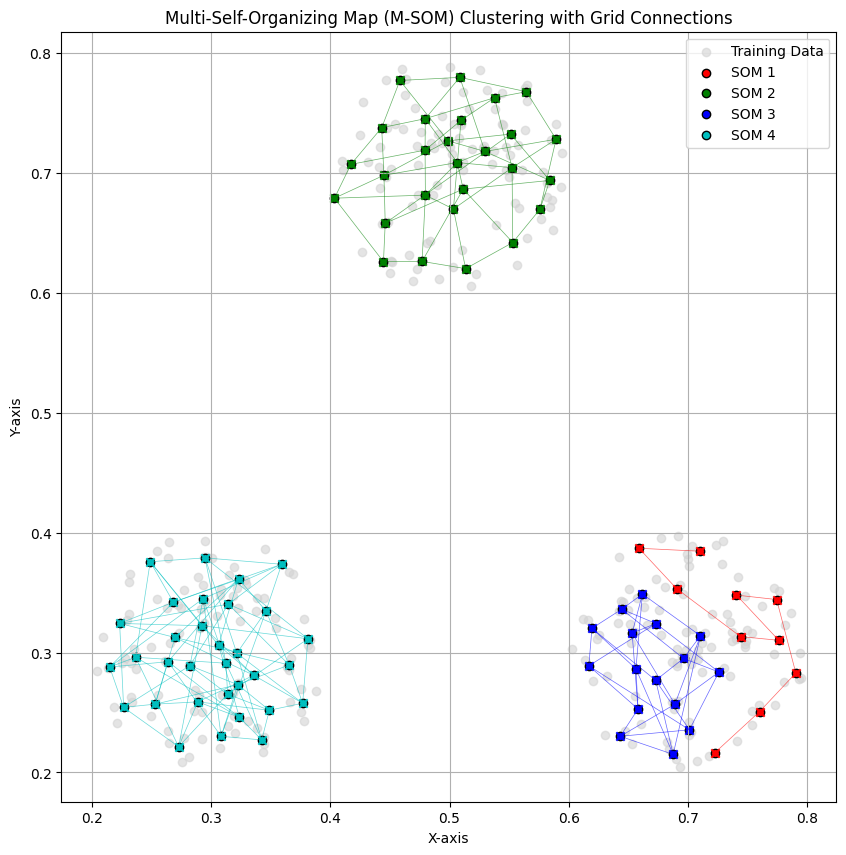

In [8]:
# Example Usage of the M-SOM Implementation

# Adjustable Parameters
M = 4  # Number of partner SOMs
N = 2  # Input dimension (must be <= 6)
g = 5  # Grid dimension (up to 5)
# Define grid dimensions for each SOM (up to 5D)
grid_dims_list = [
    [10],             # SOM 1: 2D grid
    (3, 3, 3),          # SOM 2: 3D grid
    (2, 2, 2, 2),       # SOM 3: 4D grid
    (2, 2, 2, 2, 2)     # SOM 4: 5D grid
]
learning_rate_initial = 2
learning_rate_end = 0.01
neighborhood_size_initial = 1.0
max_iterations = 10000  # Total training iterations

# Data Generation Parameters
num_circles = 3
num_points_per_circle = 100
# Define centers of the three circles within the unit square
centers = [(0.3, 0.3), (0.7, 0.3), (0.5, 0.7)]
radii = [0.1, 0.1, 0.1]

# Generate Training Data
data = generate_circular_data(num_points_per_circle, centers, radii)
print(f"Generated {len(data)} training data points.")

# Initialize M-SOM
msom = MSOM(
    input_dim=N,
    M=M,
    grid_dims_list=grid_dims_list,
    learning_rate_initial=learning_rate_initial,
    learning_rate_end=learning_rate_end,
    neighborhood_size_initial=neighborhood_size_initial,
    g=g
)

# Train M-SOM
msom.train(data, max_iterations)
print("Training completed.")

# Retrieve and Save Centers
centers = msom.get_all_centers()
save_centers_to_file(centers, "PA-D_net.txt")

# Plot the results with grid connections
plot_msom(data, msom, centers_filename="PA-D_net.txt", show=True)
